# Using the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class
This is a tutorial for using the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class.  

Like the [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session) class, the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class is a wrapper for much of the functionality in PBjam. The [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session) class actually just creates a list of [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class instances and loops over this list during the peakbagging process.

The star class is useful if you want a bit more control over, e.g., the light curve reduction and power spectrum computation, but otherwise we recommend using the [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session) class.

## Preparing the data
The [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class takes [lightkurve.periodogram](https://docs.lightkurve.org/api/lightkurve.periodogram.Periodogram.html) objects as data input, while the remaining parameters are identical to those for [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session), although lists are not allowed here since a star class instance only refers to a single target. 

Let's create a [Lightkurve lightcurve](https://docs.lightkurve.org/api/lightkurve.lightcurve.LightCurve.html) object and then compute the periodogram. 

In [1]:
import lightkurve as lk
import pbjam as pb
print(f'Lightkurve version {lk.__version__}')
print(f'PBjam version {pb.__version__}')

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Lightkurve version 1.5.dev
PBjam version 0.1.10dev


While the PDCSAP pipeline does a pretty good job in preparing light curves for asteroseismology, we might want to perform some manipulation of the data. Since we're using [Lightkurve](https://docs.lightkurve.org/), for the purposes of this exercise we'll just use some of the built-in functions.

In [2]:
lcs = lk.search_lightcurvefile('KIC4448777').download_all()
lc = lcs.PDCSAP_FLUX.stitch().normalize().flatten(window_length=401).remove_outliers(4)

/Users/davies/Software/lightkurve/lightkurve/lightcurve.py:667: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  LightkurveWarning)


We can have a quick look at the time series to check that everything looks good

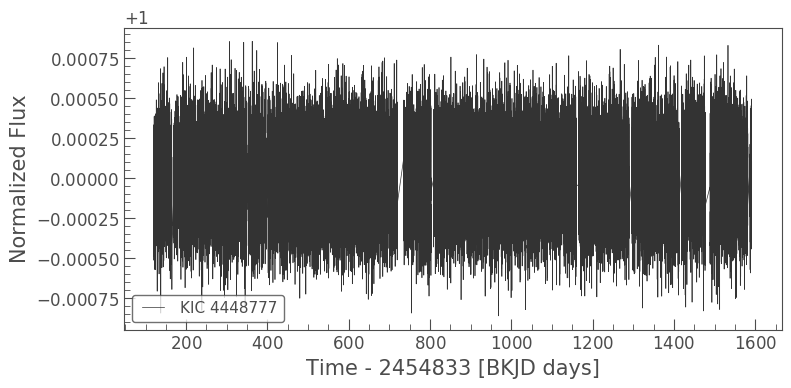

In [3]:
lc.plot()

Now lets compute the power density spectrum

In [4]:
pg = lc.to_periodogram(normalization='psd', minimum_frequency=150.0)

The functions in PBjam work best if you are using the SNR spectrum. That is, the powerspectrum with the background noise level divided out. Again, this can be done manually, but Lightkurve has a built-in function for this too, so for the purposes of this tutorial we'll just use that.

In [5]:
pg = pg.flatten()

Again, lets just have a quick look to make sure the power spectrum looks good

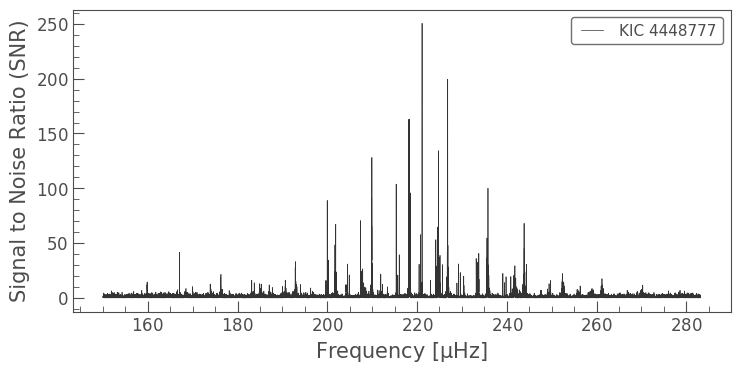

In [6]:
pg.plot()

## Alright, time to peakbag
We'll start by defining some of the physical parameters of the star we're looking at, in this case we downloaded the lightcurve for KIC4448777. 

**Note:** When calling the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class here we don't actually have to use the KIC identifier as the ID, we can pick any name we want. Only [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session) needs a proper identifier, since it uses [Lightkurve.search_lightcurvefile](https://docs.lightkurve.org/api/lightkurve.search.search_lightcurvefile.html).

In [7]:
ID = 'catname'
numax = (220.0, 3.0)
dnu = (16.97, 0.05)
teff = (4750, 100)
bp_rp = (1.34, 0.1)

Now that we have a power spectrum and some input parameters we can initialize the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class instance. 

In [8]:
st = pb.star(ID, pg, numax, dnu, teff, bp_rp)

Like [session](https://pbjam.readthedocs.io/en/latest/session.html#pbjam.session.session), the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class has a 'do-it-all' functionality, which can be used by calling the class instance:

Starting KDE estimation
Using 130 data points for the KDE
Steps taken: 2000
Steps taken: 3000
Steps taken: 4000
Steps taken: 5000
Chains reached stationary state after 5000 iterations.
Starting Asy_peakbag
Steps taken: 2000
Chains reached stationary state after 2000 iterations.
Starting peakbagging run


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [back, height2, height0, l2, l0, width2, width0]


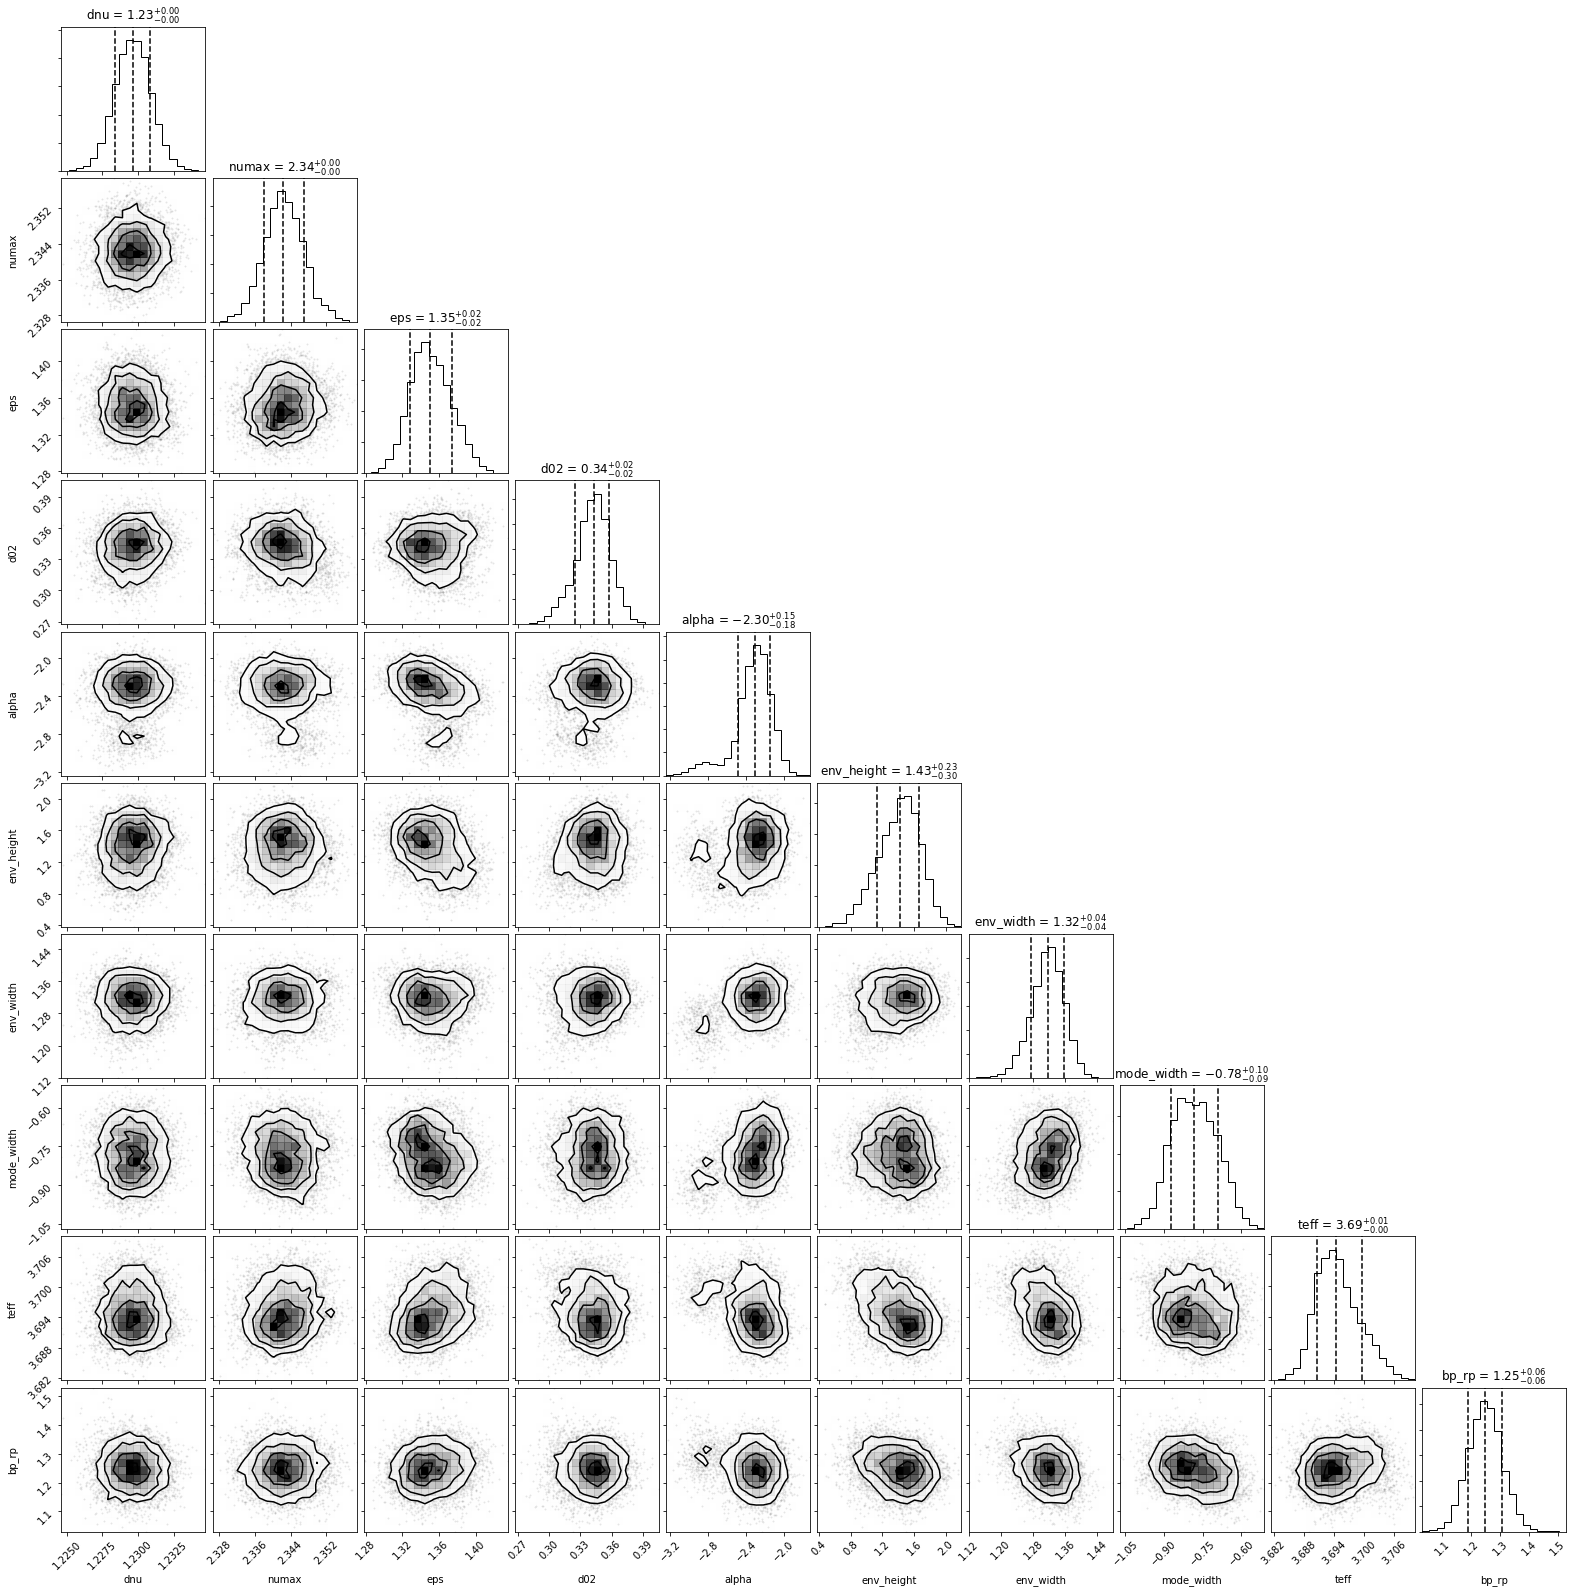

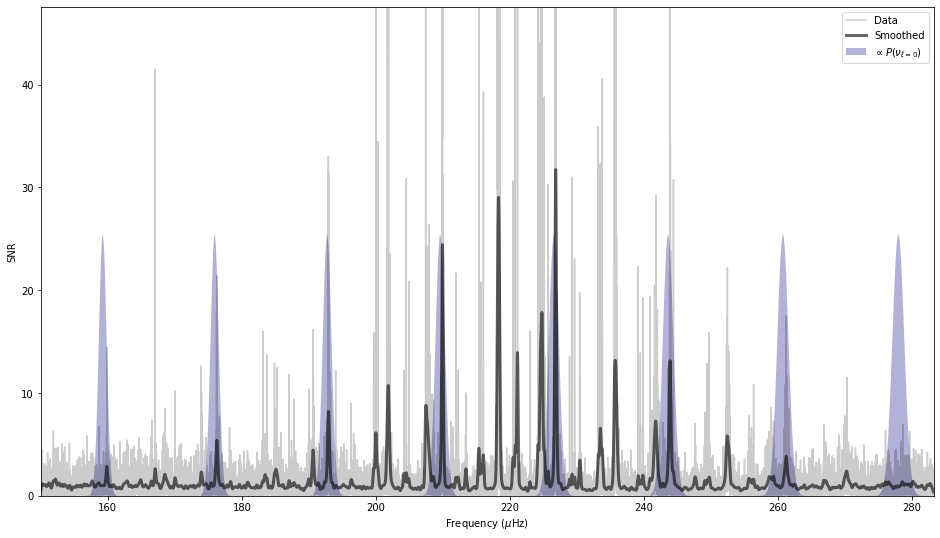

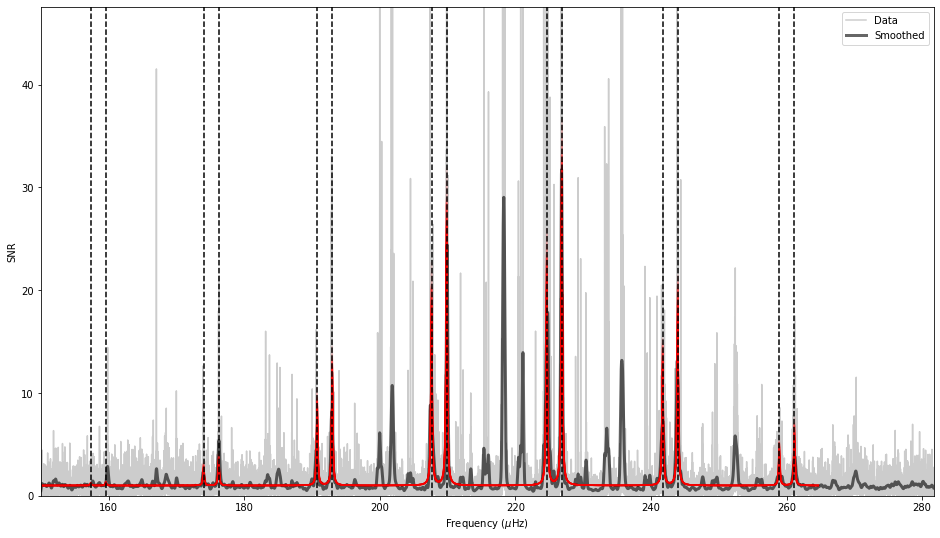

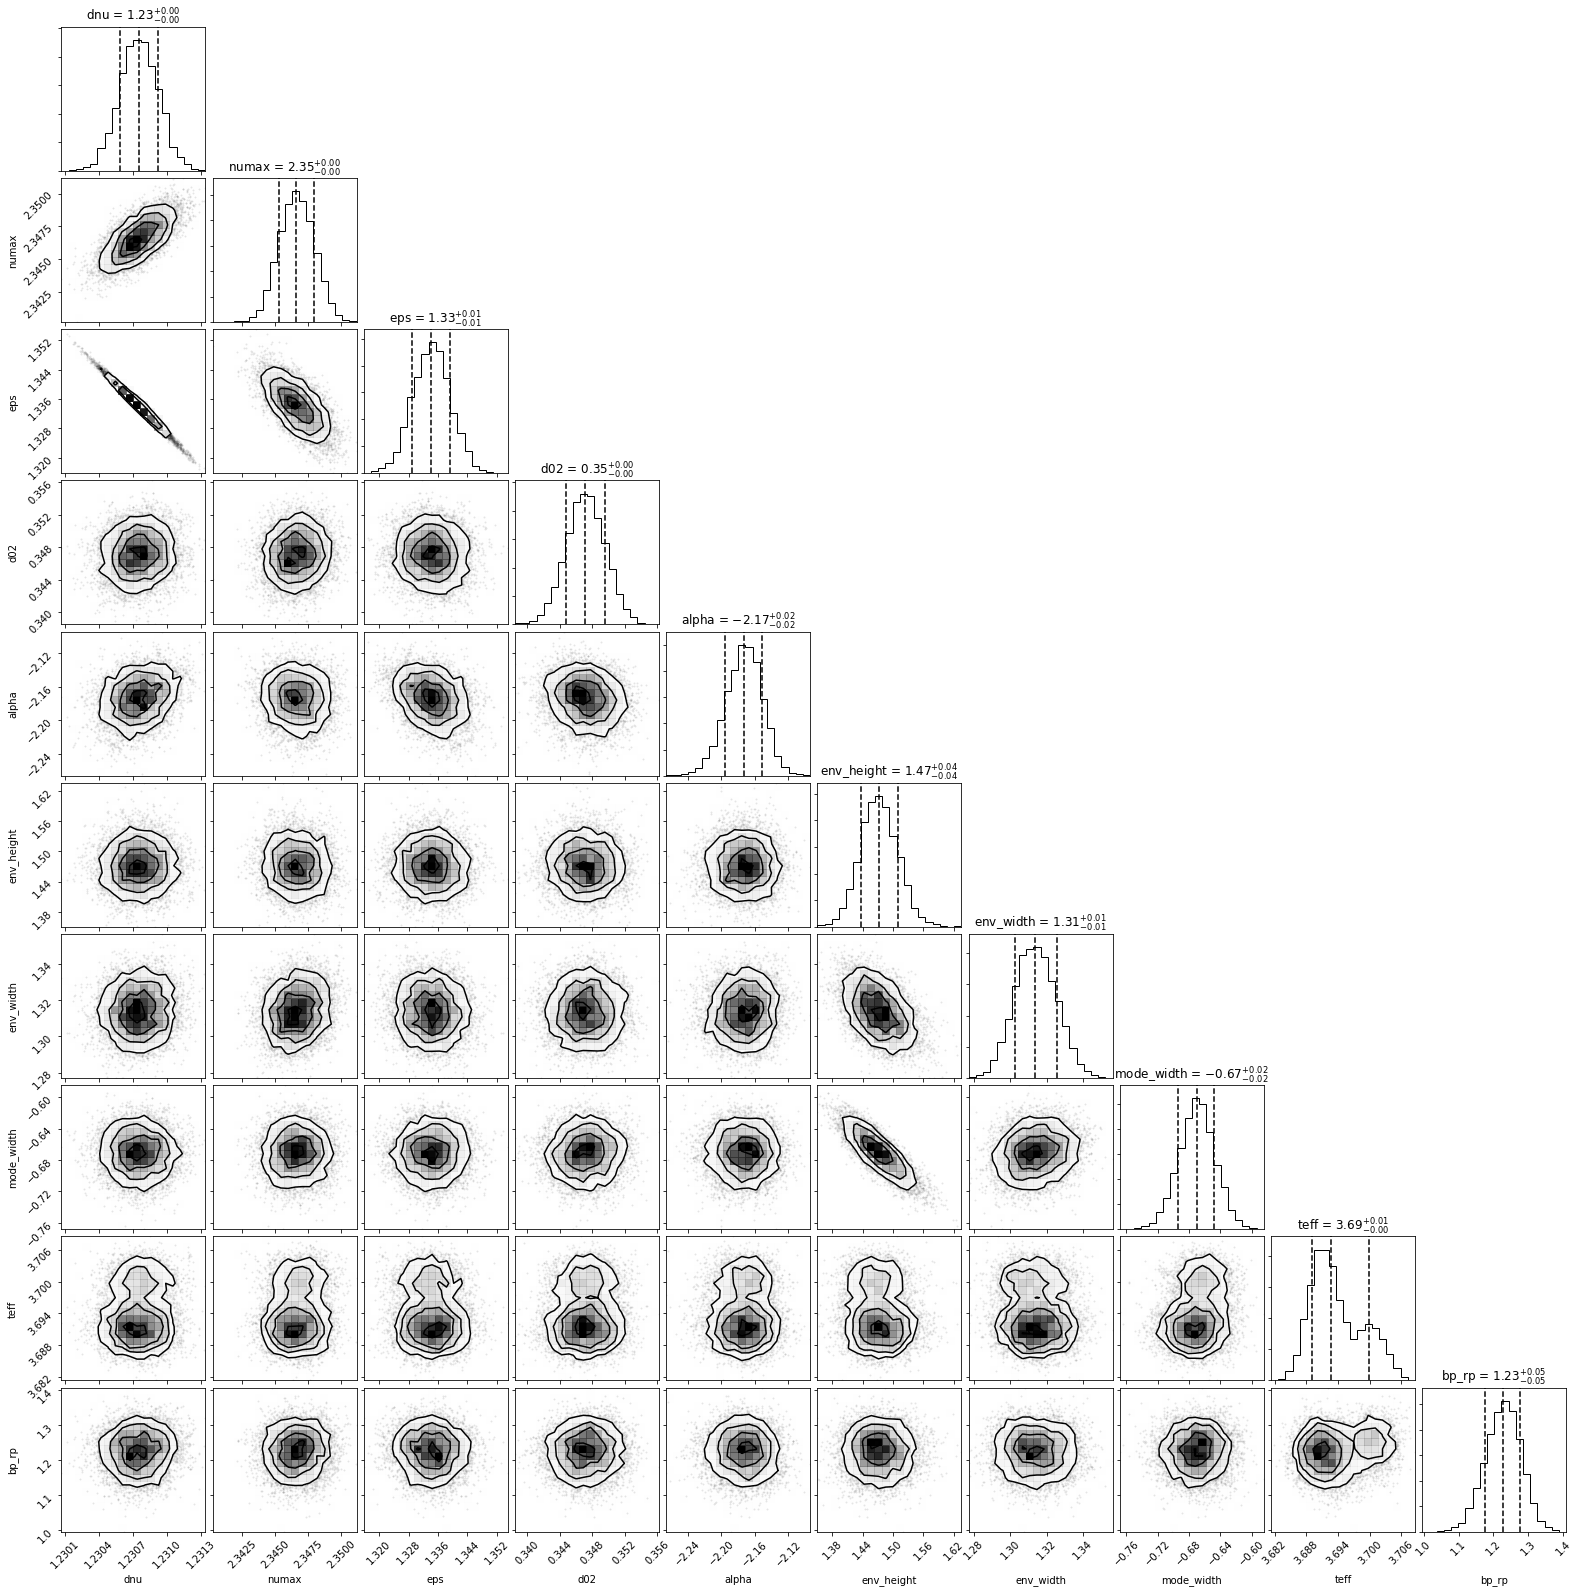

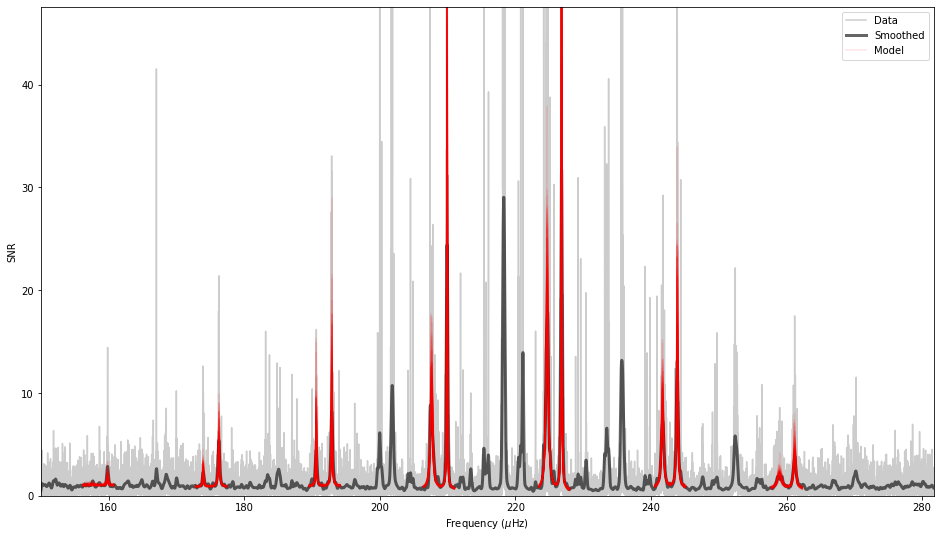

In [9]:
st(norders = 7, make_plots=True)

## A bit more step-by-step
In the following we'll show the different steps that PBjam takes when you ask it to 'do-it-all'. It's not a fully detailed explanation, with theory and everything, but should give you a bit more of a feel for the way PBjam is set up. For even more details, see the [Advanced notebook](https://pbjam.readthedocs.io/en/latest/example-advanced.html). 

The first step that PBjam takes is to construct a prior and determine the most likely starting locaiton for a spectrum model using the p-mode asymptotic relation. 

PBjam does first computing a Kernel Density ([KDE](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html#statsmodels.nonparametric.kernel_density.KDEMultivariate)) estimate based on large sample of previous fits to other stars. This encodes the knowledge of the covariance of these parameters, for a wide range of stars. Given a set of input parameters $\nu_{max}$, $\Delta \nu$, $T_{\mathrm{eff}}$, $B_p-R_p$, this prior KDE is then sampled to find the most likely starting location.

This is done calling the [star.run_kde](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.run_kde) function.

In [10]:
st = pb.star(ID, pg, numax, dnu, teff, bp_rp, path = '.')
st.run_kde()

Starting KDE estimation
Using 130 data points for the KDE
Steps taken: 2000
Steps taken: 3000
Chains reached stationary state after 3000 iterations.


The way we can evaluate the $\epsilon$ value that PBjam finds, is to plot where it thinks the $l=0$ modes are likely to be.

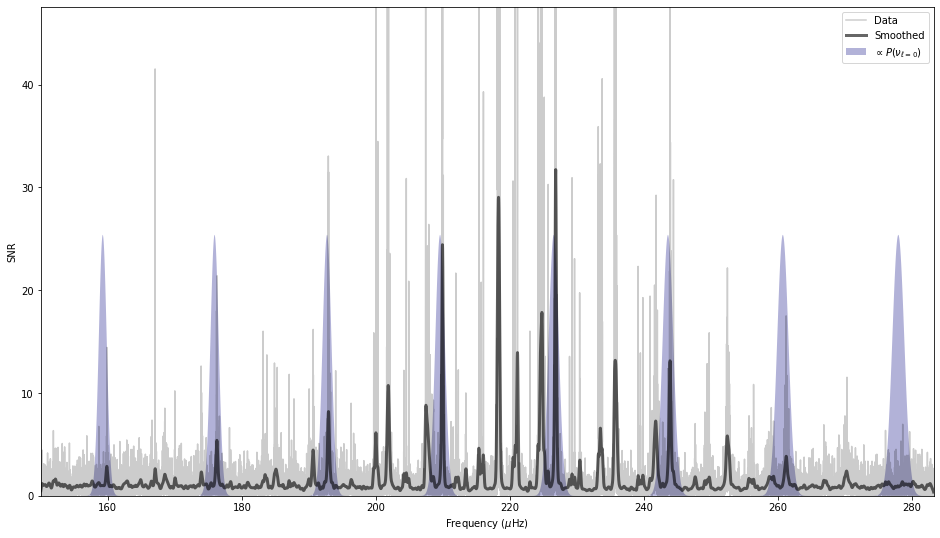

In [11]:
st.kde.plot_spectrum(pg);

The purple distributions indicate where PBjam thinks the $l=0$ modes are. At this point PBjam hasn't actually evaluated the power spectrum yet, it's only working based on the physical parameters and prior information we have given it. The result looks pretty good.

The next step is to fit an asymptotic relation to the data, using the KDE as a prior. In this case we do this using the [asy_peakbag](https://pbjam.readthedocs.io/en/latest/asy_peakbag.html) module, by calling [star.run_asy_peakbag](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.run_asy_peakbag)

In [12]:
st.run_asy_peakbag(norders=7)

Starting Asy_peakbag
Steps taken: 2000
Chains reached stationary state after 2000 iterations.


The result can be examined using a corner plot:

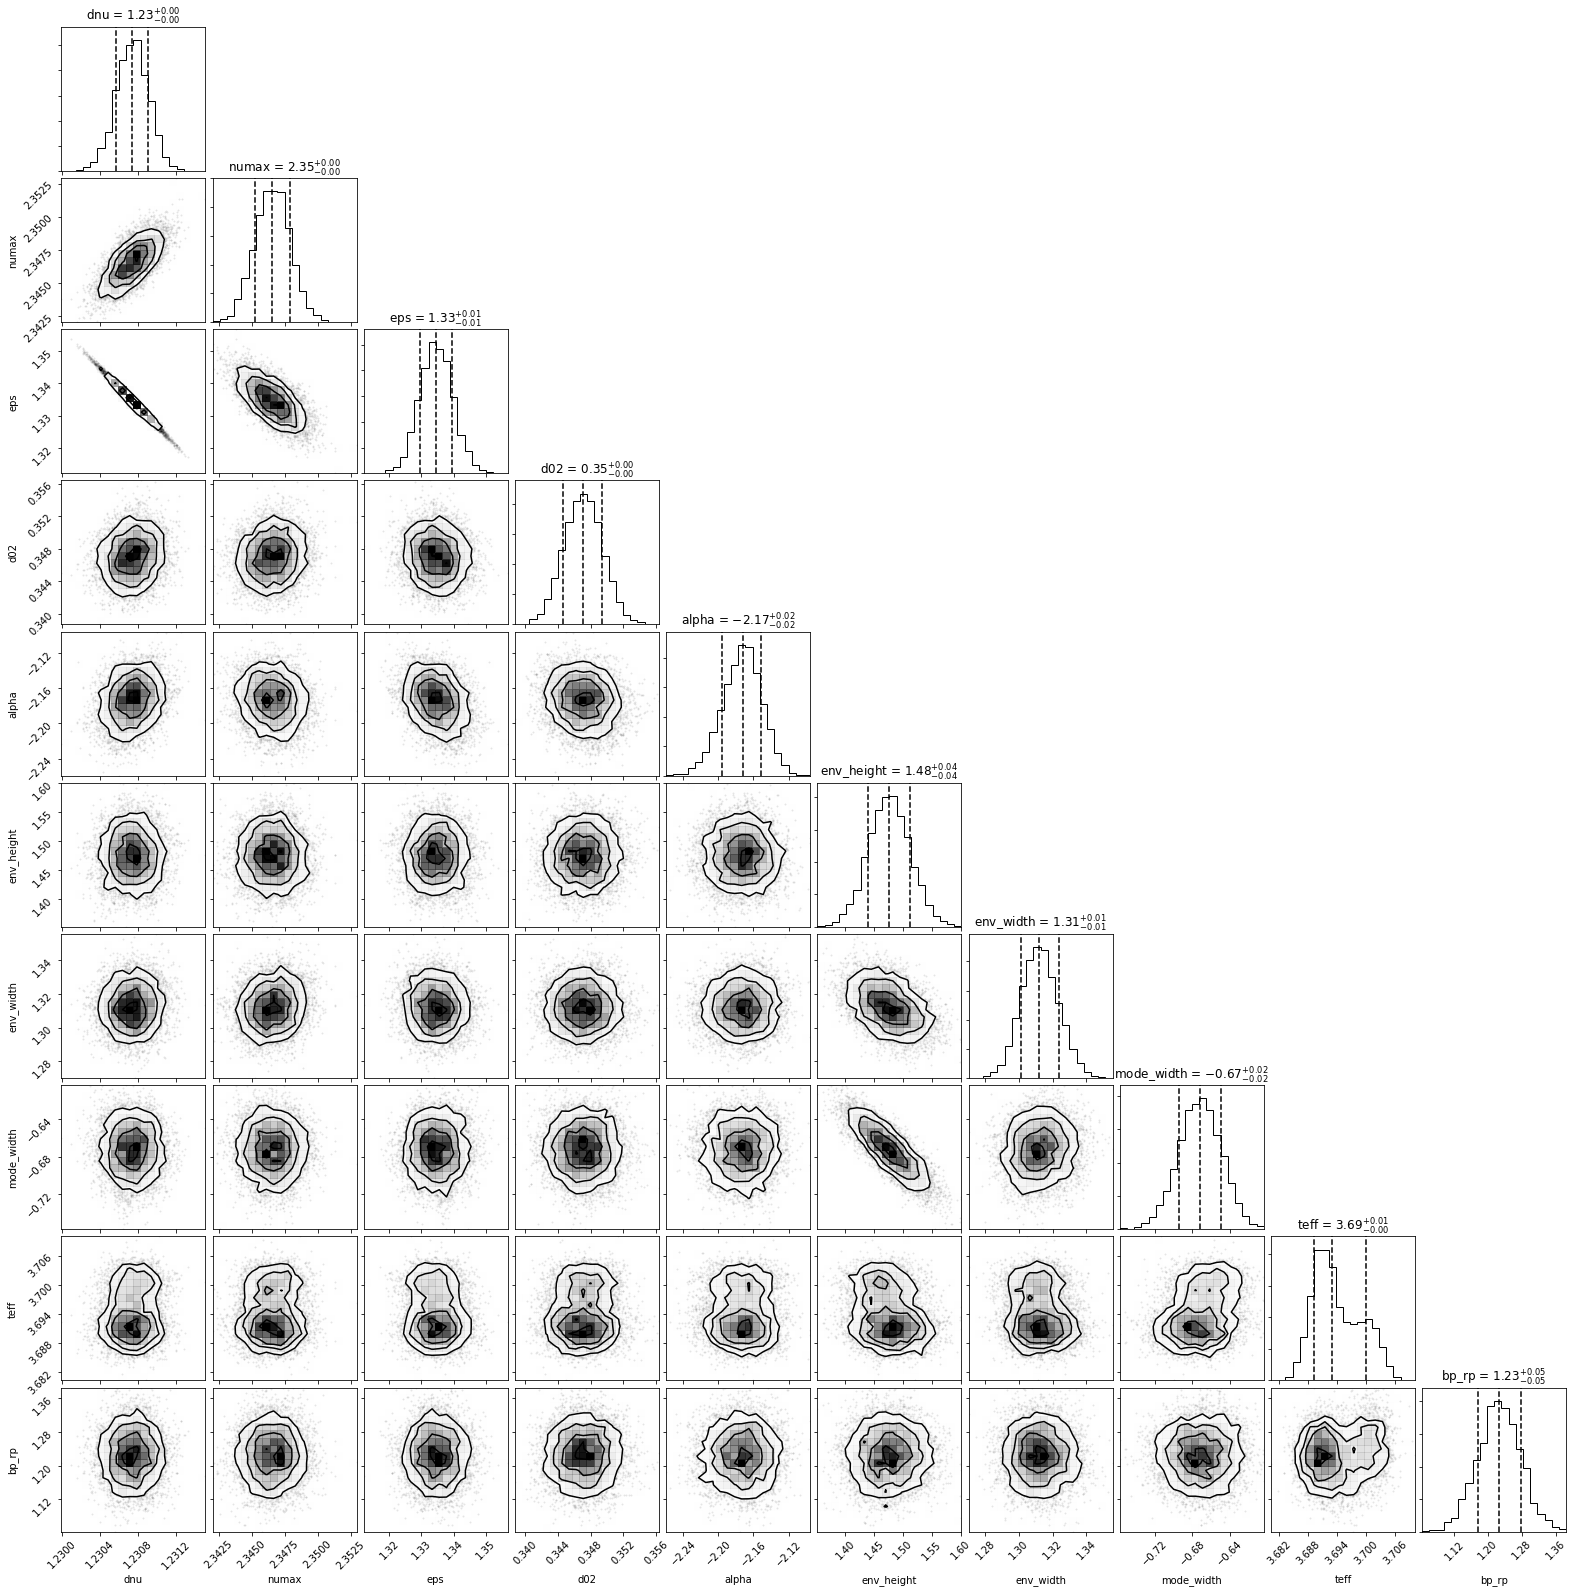

In [13]:
st.asy_fit.plot_corner();

This plot shows all the parameters that [asy_peakbag](https://pbjam.readthedocs.io/en/latest/asy_peakbag.html) uses. The main parameters of interest are $\nu_{max}$, $\Delta \nu$, and $\epsilon$.  The remaining are less important, but may provide clues if something goes wrong during the fit. 

**Note** The $T_{\mathrm{eff}}$ and $B_p-R_p$ might differ slightly from the initial guesses. In this case the true value of $B_p-R_p$ is 1.23 [(Gaia Collaboration et al. 2018)](http://vizier.u-strasbg.fr/viz-bin/VizieR-S?Gaia%20DR2%202100458330254478464). 

We can plot a sub-set of the best-fitting models on top of the spectrum:

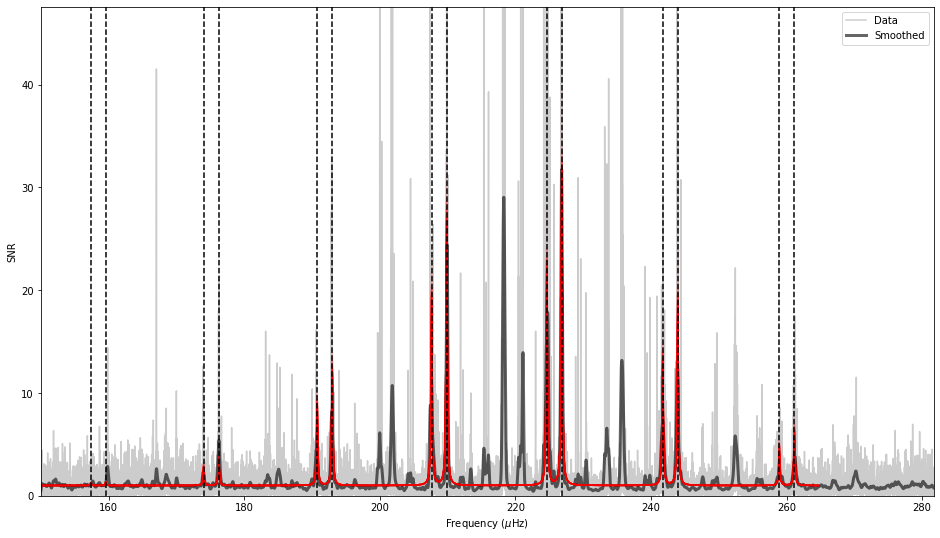

In [14]:
st.asy_fit.plot_spectrum();

Now we have a bit better view of what the initial guess for the last peakbagging step will be, and you can see it already looks pretty good. To first order, [asy_peakbag](https://pbjam.readthedocs.io/en/latest/asy_peakbag.html) is probably good enough to get a reasonable estimate of the mode frequencies. However, second order effects like acoustic glitches are not currently incorporated into [asy_peakbag](https://pbjam.readthedocs.io/en/latest/asy_peakbag.html). Furthermore, the above result is also strongly influenced by the prior, and the height ratio between the $l=2$ and $l=0$ which is fixed to $0.7$. 

This is why we have the final peakbagging step, where we allow the mode frequencies to move freely and using less informative priors on the mode heights and widths.

In [15]:
st.run_peakbag()

Starting peakbagging run


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [back, height2, height0, l2, l0, width2, width0]


The result can be shown using the plot_spectrum method

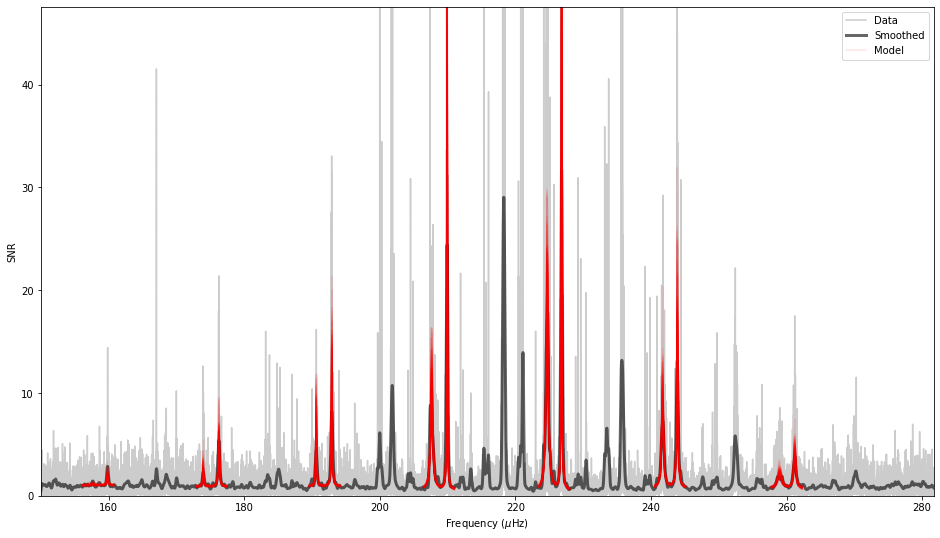

In [16]:
st.peakbag.plot_spectrum();

The sample of models drawn from the posterior all appear to agree on where the modes are and their amplitudes seem to be reasonable. The resulting summary dataframe from [pymc3.stats.summary](https://docs.pymc.io/api/stats.html#pymc3.stats.summary) is written to the fit directory.

## Would you like to know more?
Read the API for the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class and check out the [other tutorials](https://pbjam.readthedocs.io/en/latest/usage.html).